# Examples of running HypoInPy with utility functions

In [1]:
import os, sys,glob
import pandas as pd
import numpy as np
from hypoinvpy import core as hc
from hypoinvpy import utils

## Convert station information from json database to CSV
The example here uses the *.json file saved by EQTransforer downloading step. The CSV file is for general purpose. To reformat it for HypoInverse code, please see the next example.

In [2]:
infile='input/EQT_station_list.json'
utils.stainfo_json2csv(infile,outfile='input/EQT_station_list.csv')
stainfo=utils.stainfo_json2csv(infile)
print(stainfo)

   network station channel   latitude   longitude  elevation
0       CI     CCC     HHZ  35.524950 -117.364530      670.0
1       CI     CCC     HHE  35.524950 -117.364530      670.0
2       CI     CCC     HHN  35.524950 -117.364530      670.0
3       GS    CA01     HH2  35.665120 -117.423680      570.4
4       GS    CA01     HH1  35.665120 -117.423680      570.4
5       GS    CA01     HHZ  35.665120 -117.423680      570.4
6       GS    CA03     HH2  35.622040 -117.569110      762.2
7       GS    CA03     HH1  35.622040 -117.569110      762.2
8       GS    CA03     HHZ  35.622040 -117.569110      762.2
9       GS    CA04     HH2  35.478330 -117.560200     1005.4
10      GS    CA04     HH1  35.478330 -117.560200     1005.4
11      GS    CA04     HHZ  35.478330 -117.560200     1005.4
12      GS    CA05     HH2  35.589260 -117.286890      612.1
13      GS    CA05     HH1  35.589260 -117.286890      612.1
14      GS    CA05     HHZ  35.589260 -117.286890      612.1
15      GS    CA06     H

## Reformat station information for HypoInverse code.
The `HypoInvPy.core.reformat_stainfo()` function takes input in `json` or `csv` format. See the source code or use `help()` to get detailed usage information of this function. 

* `force_channel_type` option is to force all channels to the specified type. This is because in some earthquake detection and association steps, the original channel types might be lost, making it impossible to link the phase data with station information.
* `rename_component_dict` option is to rename component names. This is needec when some components originally having 1 or 2 in the names. These original names sometimes are not kept through the earthquake detection and association steps.

In [3]:
hc.reformat_stainfo(infile,'input/EQT_station_list.sta',informat='json',force_channel_type='HH',
                   rename_component_dict={'1':'N','2':'E'})

## Setup parameters for HypoInverse code
Major parameters to run the code are carried through with a container class named `HypoInvPy.core.HypoInvConfig()`. This class is simplified from the `config()` class in `Hypo-Interface-Py`. In `HypoInvPy`, I also reduced the number of metadata/parameters, to focus only on required key parameters.

Examples here use the phase information directly from the `EQTransformer` association step. The station information file has been reformated as shown in the previous cell. 

In [4]:
# modified from https://github.com/YijianZhou/Hypo-Interface-Py
phase_file='input/EQT_Y2000.phs'
station_file='input/EQT_station_list.sta'
pmodel='input/velo_p_eg.cre'
smodel='input/velo_s_eg.cre'
lat_code='N'
lon_code='W'
depth_try_list=np.arange(0,20,1)
min_nsta=4 #minimum number of stations to relocate the earthquake. 4 is recommeneded as the minimum to get a reliable location.
keep_summary_files=False #keep intermediate summary files from each relocation run?
outputdir='output'

cfg = hc.HypoInvConfig(phase_file=phase_file,station_file=station_file,
                       pmodel=pmodel,smodel=smodel,min_nsta=min_nsta,
                      lat_code=lat_code,lon_code=lon_code,ztrlist=depth_try_list)
#file names for the final summary catalogs.
out_bad = '%s/%s_bad.csv'%(outputdir,cfg.run_tag)
out_good = '%s/%s_good.csv'%(outputdir,cfg.run_tag)

## Run hypoinverse through the interface
This is the key step to run hypoinverse. I kept the way Hypo-Interface-Py uses running the code on a series of initial depths. This list is specified as `ztrlist` in the configuration step above.

In [5]:
# 1. produce parameter files for each testing initial depth.
hypparfiledir='input'
hypparfilelist=hc.generate_parfile(cfg,hypparfiledir,outdir=outputdir)

# 2. Run hypoinverse with all parameter files.
hc.run_hypoinv(hypparfilelist)

 HYPOINVERSE 2000 STARTING
6/2014 VERSION 1.40 (geoid depth possible)                            
 COMMAND?     60 STATIONS READ IN.
  FIND INPUT PHASE FILE TYPE & SET PHS(COP) & ARC(CAR) FORMATS
  INPUT IS A HYPOINVERSE ARCHIVE-2000 FILE, NO SHADOWS
  SETTING FORMATS COP 3, CAR 1
  SEQ ---DATE--- TIME REMARK -LAT-  --LON-  DEPTH  RMS PMAG  NUM  ERH  ERZ  ID
    1 2019- 9- 1  0:02     - 35 39  117 24   0.00 0.19  0.0    6  1.7 20.0    200001
    2 2019- 9- 1  0:02     - 35 39  117 23   0.00 0.29  0.0    6  2.6 26.9    200002
    3 2019- 9- 1  0:03     - 35 41  117 26   0.39 0.10  0.0    6  1.7 14.7    200003
    4 2019- 9- 1  0:04     - 35 41  117 23   0.00 0.25  0.0    5  2.5 24.1    200004
    5 2019- 9- 1  0:05     - 35 32  117  9   0.00 0.30  0.0    4 25.8 27.7    200005
 *** DISTANCE & RESIDUAL WEIGHTING CANCELLED FOR EVENT: 2019  9  1  0  5
 *** ABANDON EVENT WITH ONLY 3 READINGS:2019  9  1  0  5
    7 2019- 9- 1  0:06     - 35 45  117 31   0.00 0.26  0.0    6  5.0 24.8    200007

Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


  771 2019- 9- 1 13:31     - 35 38  117 39   0.00 2.30  0.0    6 89.1 88.9    200771
  772 2019- 9- 1 13:33     - 35 35  117 26   0.63 0.01  0.0    4 12.5  2.0    200772
  773 2019- 9- 1 13:33     - 35 34  117 30   5.73 0.04  0.0    5  8.6  5.1    200773
  774 2019- 9- 1 13:34     - 35 49  117 42   7.66 0.07  0.0    6  5.7 13.6    200774
  775 2019- 9- 1 13:34     - 35 39  117 26   7.91 0.07  0.0    6  8.1  9.0    200775
  776 2019- 9- 1 13:35     - 35 32  117 31   5.95 0.04  0.0    6  7.4  8.5    200776
  777 2019- 9- 1 13:36     - 35 36  117 26   5.06 0.01  0.0    4 12.0  3.5    200777
  778 2019- 9- 1 13:36     - 35 35  117 31   5.88 0.06  0.0    6 10.4  2.2    200778
  779 2019- 9- 1 13:37     - 35 36  117 28   8.71 0.04  0.0    6 10.0  2.1    200779
  780 2019- 9- 1 13:38     - 35 40  117 32   7.20 0.14  0.0    6 12.7 10.2    200780
  SEQ ---DATE--- TIME REMARK -LAT-  --LON-  DEPTH  RMS PMAG  NUM  ERH  ERZ  ID
  781 2019- 9- 1 13:39     - 35 42  117 34   7.09 0.03  0.0    6  8.7  

Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


  SEQ ---DATE--- TIME REMARK -LAT-  --LON-  DEPTH  RMS PMAG  NUM  ERH  ERZ  ID
 1231 2019- 9- 1 20:16     - 35 38  117 33   9.75 0.06  0.0    6 11.4  2.4    201232
 1232 2019- 9- 1 20:16     - 35 40  117 41  19.01 0.15  0.0    5 16.8  3.6    201233
 1233 2019- 9- 1 20:17     - 35 32  117 28   6.05 0.05  0.0    6  7.7  6.9    201234
 *** DISTANCE & RESIDUAL WEIGHTING CANCELLED FOR EVENT: 2019  9  1 20 18
 1234 2019- 9- 1 20:18     - 35 32  117 20  12.55 0.46  0.0    5 39.1  7.7    201235
 1235 2019- 9- 1 20:20     - 35 39  117 39  14.82 0.12  0.0    6 14.9  3.1    201236
 1236 2019- 9- 1 20:22     - 35 38  117 35  12.30 0.03  0.0    5 12.4  1.7    201237
 1237 2019- 9- 1 20:23     - 35 36  117 28  12.86 0.09  0.0    6 12.5  1.3    201238
 1238 2019- 9- 1 20:23     - 35 35  117 27   9.59 0.07  0.0    6 10.6  1.2    201239
 1239 2019- 9- 1 20:23     - 35 36  117 31   4.16 0.27  0.0    5 20.4  4.1    201240
 1240 2019- 9- 1 20:23     - 35 38  117 36   8.29 0.05  0.0    5 10.7  1.3    20124

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


 1017 2019- 9- 1 16:59     - 35 36  117 29   8.33 0.07  0.0    6 10.4  1.1    201017
 1018 2019- 9- 1 17:00     - 35 36  117 28   8.37 0.05  0.0    6  9.6  1.1    201018
 1019 2019- 9- 1 17:00     - 35 39  117 38  21.79 0.11  0.0    6 14.3  2.7    201019
 1020 2019- 9- 1 17:02     - 35 36  117 29  14.37 0.08  0.0    6 12.9  1.1    201020
  SEQ ---DATE--- TIME REMARK -LAT-  --LON-  DEPTH  RMS PMAG  NUM  ERH  ERZ  ID
 1021 2019- 9- 1 17:02       35 35  117 27   9.14 0.07  0.0    6  9.6  1.2    201021
 *** DISTANCE & RESIDUAL WEIGHTING CANCELLED FOR EVENT: 2019  9  1 17  3
 1022 2019- 9- 1 17:03     - 35 36  117 30  15.35 0.46  0.0    4 40.3  5.3    201022
 1023 2019- 9- 1 17:04     - 35 37  117 32   9.22 0.08  0.0    6 12.0  0.9    201023
 1024 2019- 9- 1 17:04     - 35 38  117 36  10.70 0.07  0.0    6 12.7  2.0    201024
 1025 2019- 9- 1 17:05     - 35 36  117 30   9.62 0.03  0.0    4 12.8  1.2    201025
 1026 2019- 9- 1 17:07     - 35 36  117 29   8.46 0.04  0.0    6  9.7  1.2    20102

## Extract inversion results based on quality

In [6]:
print('converting output sum files')
summary_filelist=glob.glob('%s/%s-*.sum'%(outputdir,cfg.run_tag))

hc.merge_summary(summary_filelist,out_good,out_bad,lat_code,lon_code)


converting output sum files
Earthquakes are saved in: output/hyp_good.csv and output/hyp_bad.csv for good and bad sources.


In [7]:
# remove intermidiate files
for fname in glob.glob('fort.*'): os.unlink(fname)
for fname in glob.glob('input/%s-*.hyp'%cfg.run_tag): os.unlink(fname)
if not keep_summary_files:
    for fname in glob.glob(outputdir+'/'+cfg.run_tag+'*.sum'): os.unlink(fname)

## Read and plot the earthquakes

In [8]:
quakes=pd.read_csv(out_good,header=None,names=["datetime","latitude","longitude","depth","magnitude","evid"])

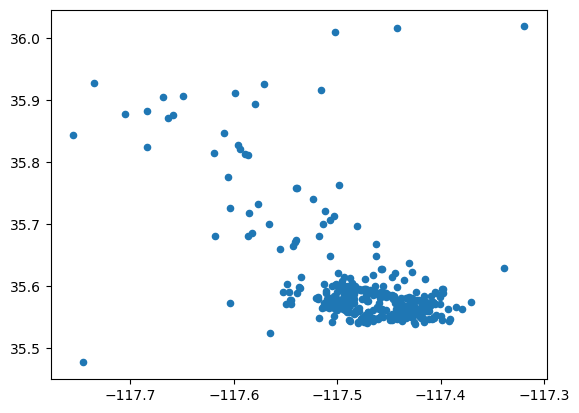

In [9]:
import matplotlib.pyplot as plt
plt.scatter(quakes.longitude,quakes.latitude,20)